In [1]:
import pandas as pd
from helpermodules import memory_handling as mh
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from functions import compute_sentiment, filtering_df, retrieve_datas, scraping_speeches, update_realtime, analysis
from functions.update_realtime import change_time
from functions.filtering_df import main as filtering
from functions.analysis import main as plot
from functions.scraping_speeches import main as scraping

#######
'''questa prima parte del codice presenta il codice che dovrebbe essere implementato 
(quello preceduto da '#') e in seguito il codice che ho utlizzato io non avendo ancora 
accesso alle funzioni, riciclando i file csv e 'pulendoli' per la task.
Le funzioni che verranno implementate devono restituire un oggetto che abbia 
la stessa forma e caratteristiche dell'oggetto finale (evidenziato nel codice)'''

yearlist = [2020,2021,2022,2023,2024]
# df_fed = scraping(yearlist) -> ALREADY RUN, STORE IN ANOTHER FILE
file = "2020-2024fedspeeches.pkl"
helper = mh.PickleHelper.pickle_load(file)
df_fed = helper.obj
df_fed['speaker'] = df_fed['speaker'].str.replace('Speech - ', '', regex=False)
df_fed['speaker'] = df_fed['speaker'].str.replace('Discussion - ', '', regex=False)


#df_prices = retrieve_datas(df_speech, deltabefore, deltaafter) -> ALREADY RUN
file2 = "2020-2024prices.pkl"
helper = mh.PickleHelper.pickle_load(file2)
df = helper.obj
print(df.columns) 
df['date'] = df['datetime'].dt.date
df_prices = df



#df_speech = computespeech()
file3 = "2020-2024speeches.pkl"
helper = mh.PickleHelper.pickle_load(file3)
df_speech = helper.obj
df_speech = df_speech[df_speech['date']>='2020-01-01']
df_speech = df_speech.sort_values(['date','timestamp'], ascending=True) #<--- OGGETTO FINALE


#df_sentiment = compute_sentiment()
file4 = "2020-2024sentiment.pkl"
helper = mh.PickleHelper.pickle_load(file4)
df_sentiment = helper.obj 


############

df_fed.rename(columns={'timestamp': 'opening_time'}, inplace=True)
#update the correct timestamp for df_speech
df_speech_final = change_time(df_speech, df_fed) #drop rate 16% e 58
#sorting the values
df_speech_final = df_speech_final.sort_values(['date','timestamp'], ascending=True)



# Define market open and close times (in ET)
market_open = pd.to_datetime('09:30:00', format='%H:%M:%S').time()
market_close = pd.to_datetime('16:00:00', format='%H:%M:%S').time()

# Extract time from 'timestamp'
df_speech_final['time'] = df_speech_final['timestamp'].dt.time

# Filter rows where 'time' is within market hours
beforefilteringvalues = len(df_speech_final.text.unique())
df_filtered = df_speech_final[(df_speech_final['time'] >= market_open) & (df_speech_final['time'] < market_close)]
afterfilteringvalues = len(df_filtered.text.unique())
print('When filtering out datas out of market time the drop ratio is ',(afterfilteringvalues/beforefilteringvalues)*100,'%\nWe have dropped ',beforefilteringvalues-afterfilteringvalues,'values') # 65% e 100 valori
df_speech_final = df_filtered.drop(columns=['time'])



df_speech=df_speech_final

Index(['datetime', 'close', 'volume'], dtype='object')
When comparing df_speech with df_fed the drop ratio is 16.15598885793872 % 
We have dropped  58 values
When filtering out datas out of market time the drop ratio is  66.44518272425249 %
We have dropped  101 values


the number of elements less than 5 mins long are 19
No price data found for speech: Strengthening the Community Reinvestment Act by Staying True to Its Core Purpose by Governor Lael Brainard on 2020-01-08 00:00:00
No price data found for speech: The Outlook for Housing by Governor Michelle W. Bowman on 2020-01-16 00:00:00
No price data found for speech: Financial Markets and Monetary Policy: Is There a Hall of Mirrors Problem? by Vice Chair Richard H. Clarida on 2020-02-21 00:00:00
No price data found for speech: Monetary Policy Strategies and Tools When Inflation and Interest Rates Are Low by Governor Lael Brainard on 2020-02-21 00:00:00
No price data found for speech: U.S. Economic Outlook and Monetary Policy by Vice Chair Richard H. Clarida on 2020-02-25 00:00:00
No price data found for speech: New Economic Challenges and the Fed's Monetary Policy Review by Chair Jerome H. Powell on 2020-08-27 00:00:00
No price data found for speech: Remarks at the Hoover Institution by Vice Chair f

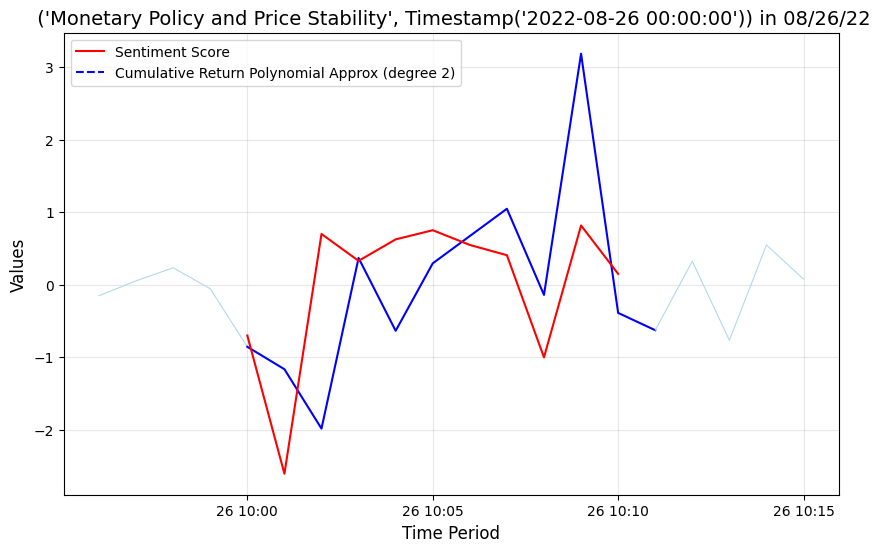

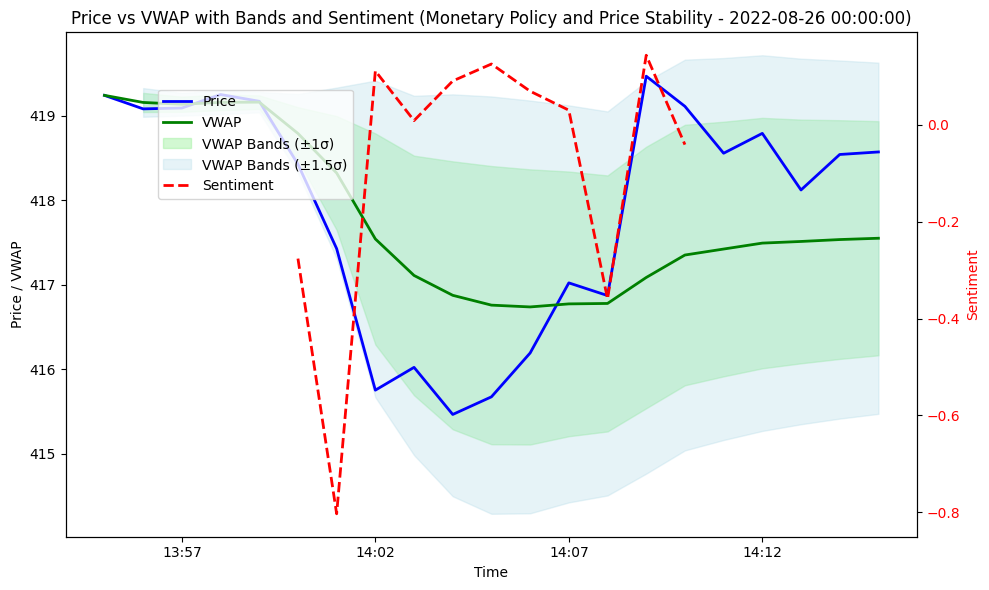

Thank you for t 





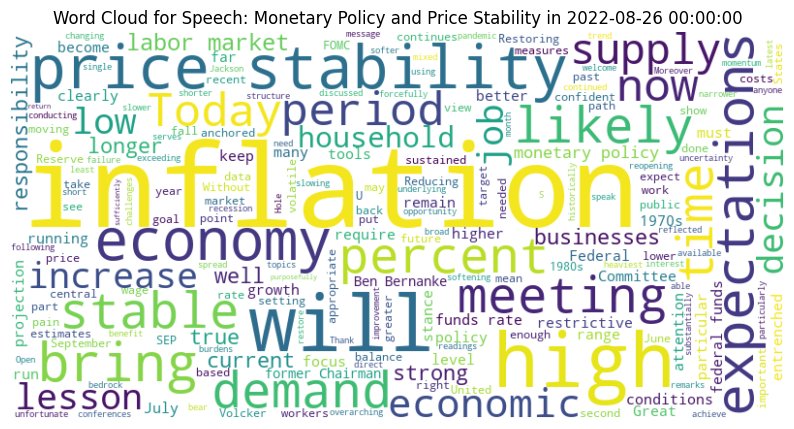

In [2]:
#combining together all the values to have a final dataframe including datas for 
#speech, sentiment, pct_change
#select a timedelta to also show prior and successive pct_change values 
deltabefore = 5
deltaafter = 4
df_speech_final, df_prices_final = filtering(df_prices, df_speech, df_sentiment,deltabefore, deltaafter) # dropped 51 values 

#plot the best top_n values for volatility over the speech time 
plot(df_speech_final, deltabefore, deltaafter, top_n=1)


In [4]:
import matplotlib.dates as mdates

In [ ]:
def plot_pricevssentiment(df, df_top_values, interval=1):
    """
    Plots the price, VWAP (Volume Weighted Average Price), VWAP bands, 
    and sentiment of an asset over time for each unique speech and date in the DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame containing the following columns:
            - 'timestamp': Time data (timestamps).
            - 'close': Asset's price data.
            - 'volume': Asset's volume data.
            - 'sentiment': Sentiment values (can have missing values).
            - 'title': Speech identifier.
            - 'date': Date of the data.
        interval (int): The interval (in minutes) used to set the time axis tick spacing.

    Returns:
        None: The function plots the time series of the price, VWAP, VWAP bands, 
              and sentiment for each unique speech and date.
    """

    best_title_date_pairs = set(zip(df_top_values['title'], df_top_values['date']))

    # Filter df for rows where (title, date) matches the pairs in best_title_date_pairs
    df_filtered = df[df.apply(lambda row: (row['title'], row['date']) in best_title_date_pairs, axis=1)]
    df = df_filtered
    # Iterate over unique combinations of speech and date
    for speech, date in df[['title', 'date']].drop_duplicates().itertuples(index=False):
        # Filter the DataFrame for the specific speech and date
        df_filtered = df[(df['title'] == speech) & (df['date'] == date)]

        # Assign variables
        time = df_filtered['timestamp']
        prices = df_filtered['close']
        volumes = df_filtered['volume']
        sentiment = df_filtered['finbert_score']

        # Handle missing sentiment values (exclude from plot)
        sentiment_valid = sentiment.dropna()
        time_sentiment = time[sentiment_valid.index]



        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Set the x-axis locator and formatter for time intervals
        ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=interval))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.tick_params(axis='x', rotation=45)

        # Plot prices
        if deltaafter != 0:
            if deltabefore > 0:
                plt.plot(time[:deltabefore+1], prices[:deltabefore+1], color="lightblue", linewidth=0.75)
            plt.plot(time[deltabefore:-deltaafter], prices[deltabefore:-deltaafter], color="blue", linewidth=1.5)
            if deltaafter > 0:
                plt.plot(time[-deltaafter-1:], prices[-deltaafter-1:], color="lightblue", linewidth=0.75)
        else:
            if deltabefore > 0:
                plt.plot(time[:deltabefore+1], prices[:deltabefore+1], color="lightblue", linewidth=0.75)
            plt.plot(time[deltabefore:], prices[deltabefore:], color="blue", linewidth=1.5)


        # Plot sentiment on a secondary y-axis
        ax2 = ax1.twinx()
        ax2.plot(time_sentiment, sentiment_valid, color='red', label='Sentiment', linewidth=2, linestyle='dashed')
        ax2.set_ylabel('Sentiment', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Title and labels
        ax1.set_title(f'Price vs VWAP with Bands and Sentiment ({speech} - {date})')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price / VWAP')

        # Rotate x-axis labels to make them readable
        plt.xticks(rotation=45)

        # Show the legends
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

        # Display the plot
        plt.tight_layout()  # Adjust layout to avoid overlap
        plt.show()

In [ ]:
def plot_volumevssentiment(df, df_top_values, interval=1):
    """
    Plots the price, VWAP (Volume Weighted Average Price), VWAP bands, 
    and sentiment of an asset over time for each unique speech and date in the DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame containing the following columns:
            - 'timestamp': Time data (timestamps).
            - 'close': Asset's price data.
            - 'volume': Asset's volume data.
            - 'sentiment': Sentiment values (can have missing values).
            - 'title': Speech identifier.
            - 'date': Date of the data.
        interval (int): The interval (in minutes) used to set the time axis tick spacing.

    Returns:
        None: The function plots the time series of the price, VWAP, VWAP bands, 
              and sentiment for each unique speech and date.
    """

    best_title_date_pairs = set(zip(df_top_values['title'], df_top_values['date']))

    # Filter df for rows where (title, date) matches the pairs in best_title_date_pairs
    df_filtered = df[df.apply(lambda row: (row['title'], row['date']) in best_title_date_pairs, axis=1)]
    df = df_filtered
    # Iterate over unique combinations of speech and date
    for speech, date in df[['title', 'date']].drop_duplicates().itertuples(index=False):
        # Filter the DataFrame for the specific speech and date
        df_filtered = df[(df['title'] == speech) & (df['date'] == date)]

        # Assign variables
        time = df_filtered['timestamp']
        prices = df_filtered['close']
        volumes = df_filtered['volume']
        sentiment = df_filtered['finbert_score']

        # Handle missing sentiment values (exclude from plot)
        sentiment_valid = sentiment.dropna()
        time_sentiment = time[sentiment_valid.index]



        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Set the x-axis locator and formatter for time intervals
        ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=interval))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.tick_params(axis='x', rotation=45)

        # Plot volumes
        if deltaafter != 0:
            if deltabefore > 0:
                plt.plot(time[:deltabefore+1], volumes[:deltabefore+1], color="lightblue", linewidth=0.75)
            plt.plot(time[deltabefore:-deltaafter], volumes[deltabefore:-deltaafter], color="blue", linewidth=1.5)
            if deltaafter > 0:
                plt.plot(time[-deltaafter-1:], volumes[-deltaafter-1:], color="lightblue", linewidth=0.75)
        else:
            if deltabefore > 0:
                plt.plot(time[:deltabefore+1], volumes[:deltabefore+1], color="lightblue", linewidth=0.75)
            plt.plot(time[deltabefore:], volumes[deltabefore:], color="blue", linewidth=1.5)


        # Plot sentiment on a secondary y-axis
        ax2 = ax1.twinx()
        ax2.plot(time_sentiment, sentiment_valid, color='red', label='Sentiment', linewidth=2, linestyle='dashed')
        ax2.set_ylabel('Sentiment', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Title and labels
        ax1.set_title(f'Price vs VWAP with Bands and Sentiment ({speech} - {date})')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price / VWAP')

        # Rotate x-axis labels to make them readable
        plt.xticks(rotation=45)

        # Show the legends
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

        # Display the plot
        plt.tight_layout()  # Adjust layout to avoid overlap
        plt.show()

In [ ]:
def plot_pctchangevssentiment(df, df_top_values, interval=1):
    """
    Plots the price, VWAP (Volume Weighted Average Price), VWAP bands, 
    and sentiment of an asset over time for each unique speech and date in the DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame containing the following columns:
            - 'timestamp': Time data (timestamps).
            - 'close': Asset's price data.
            - 'volume': Asset's volume data.
            - 'sentiment': Sentiment values (can have missing values).
            - 'title': Speech identifier.
            - 'date': Date of the data.
        interval (int): The interval (in minutes) used to set the time axis tick spacing.

    Returns:
        None: The function plots the time series of the price, VWAP, VWAP bands, 
              and sentiment for each unique speech and date.
    """

    best_title_date_pairs = set(zip(df_top_values['title'], df_top_values['date']))

    # Filter df for rows where (title, date) matches the pairs in best_title_date_pairs
    df_filtered = df[df.apply(lambda row: (row['title'], row['date']) in best_title_date_pairs, axis=1)]
    df = df_filtered
    # Iterate over unique combinations of speech and date
    for speech, date in df[['title', 'date']].drop_duplicates().itertuples(index=False):
        # Filter the DataFrame for the specific speech and date
        df_filtered = df[(df['title'] == speech) & (df['date'] == date)]

        # Assign variables
        pct_change = df_filtered['pct_change'].values * 100
        time = df_filtered['timestamp']
        prices = df_filtered['close']
        volumes = df_filtered['volume']
        sentiment = df_filtered['finbert_score']

        # Handle missing sentiment values (exclude from plot)
        sentiment_valid = sentiment.dropna()
        time_sentiment = time[sentiment_valid.index]



        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Set the x-axis locator and formatter for time intervals
        ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=interval))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.tick_params(axis='x', rotation=45)

        # Plot pct_change
        if deltaafter != 0:
            if deltabefore > 0:
                plt.plot(time[:deltabefore+1], pct_change[:deltabefore+1], color="lightblue", linewidth=0.75)
            plt.plot(time[deltabefore:-deltaafter], pct_change[deltabefore:-deltaafter], color="blue", linewidth=1.5)
            if deltaafter > 0:
                plt.plot(time[-deltaafter-1:], pct_change[-deltaafter-1:], color="lightblue", linewidth=0.75)
        else:
            if deltabefore > 0:
                plt.plot(time[:deltabefore+1], pct_change[:deltabefore+1], color="lightblue", linewidth=0.75)
            plt.plot(time[deltabefore:], pct_change[deltabefore:], color="blue", linewidth=1.5)


        # Plot sentiment on a secondary y-axis
        ax2 = ax1.twinx()
        ax2.plot(time_sentiment, sentiment_valid, color='red', label='Sentiment', linewidth=2, linestyle='dashed')
        ax2.set_ylabel('Sentiment', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Title and labels
        ax1.set_title(f'Price vs VWAP with Bands and Sentiment ({speech} - {date})')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price / VWAP')

        # Rotate x-axis labels to make them readable
        plt.xticks(rotation=45)

        # Show the legends
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

        # Display the plot
        plt.tight_layout()  # Adjust layout to avoid overlap
        plt.show()

In [28]:
def plot_cumretvssentiment(df, df_top_values, interval=1):
    """
    Plots the price, VWAP (Volume Weighted Average Price), VWAP bands, 
    and sentiment of an asset over time for each unique speech and date in the DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame containing the following columns:
            - 'timestamp': Time data (timestamps).
            - 'close': Asset's price data.
            - 'volume': Asset's volume data.
            - 'sentiment': Sentiment values (can have missing values).
            - 'title': Speech identifier.
            - 'date': Date of the data.
        interval (int): The interval (in minutes) used to set the time axis tick spacing.

    Returns:
        None: The function plots the time series of the price, VWAP, VWAP bands, 
              and sentiment for each unique speech and date.
    """

    best_title_date_pairs = set(zip(df_top_values['title'], df_top_values['date']))

    # Filter df for rows where (title, date) matches the pairs in best_title_date_pairs
    df_filtered = df[df.apply(lambda row: (row['title'], row['date']) in best_title_date_pairs, axis=1)]
    df = df_filtered
    # Iterate over unique combinations of speech and date
    for speech, date in df[['title', 'date']].drop_duplicates().itertuples(index=False):
        # Filter the DataFrame for the specific speech and date
        df_filtered = df[(df['title'] == speech) & (df['date'] == date)]

        # Assign variables
        pct_change = df_filtered['pct_change']
        cumret = (1 + pct_change).cumprod() - 1
        time = df_filtered['timestamp']
        prices = df_filtered['close']
        volumes = df_filtered['volume']
        sentiment = df_filtered['finbert_score']

        # Handle missing sentiment values (exclude from plot)
        sentiment_valid = sentiment.dropna()
        time_sentiment = time[sentiment_valid.index]



        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Set the x-axis locator and formatter for time intervals
        ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=interval))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.tick_params(axis='x', rotation=45)

        # Plot cumret
        if deltaafter != 0:
            if deltabefore > 0:
                plt.plot(time[:deltabefore+1], cumret[:deltabefore+1], color="lightblue", linewidth=0.75)
            plt.plot(time[deltabefore:-deltaafter], cumret[deltabefore:-deltaafter], color="blue", linewidth=1.5)
            if deltaafter > 0:
                plt.plot(time[-deltaafter-1:], cumret[-deltaafter-1:], color="lightblue", linewidth=0.75)
        else:
            if deltabefore > 0:
                plt.plot(time[:deltabefore+1], cumret[:deltabefore+1], color="lightblue", linewidth=0.75)
            plt.plot(time[deltabefore:], cumret[deltabefore:], color="blue", linewidth=1.5)


        # Plot sentiment on a secondary y-axis
        ax2 = ax1.twinx()
        ax2.plot(time_sentiment, sentiment_valid, color='red', label='Sentiment', linewidth=2, linestyle='dashed')
        ax2.set_ylabel('Sentiment', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Title and labels
        ax1.set_title(f'Price vs VWAP with Bands and Sentiment ({speech} - {date})')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price / VWAP')

        # Rotate x-axis labels to make them readable
        plt.xticks(rotation=45)

        # Show the legends
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

        # Display the plot
        plt.tight_layout()  # Adjust layout to avoid overlap
        plt.show()

In [ ]:
def find_best_volatility(top_n, df_speech):
    # Drop rows with missing values
    df = df_speech.dropna()
    
    # Create a dictionary to store volatilities and indices
    volatility_dict = {}
    index_dict = {}  # To store indices for each link
    
    # Get the unique list of links
    linklist = df['link'].unique().tolist()
    
    # Calculate the volatility for each link and track indices
    for link in linklist:
        # Calculate volatility
        volatility = df[df['link'] == link]['pct_change'].std()
        volatility_dict[link] = volatility
        
        # Track indices for the link
        indices = df[df['link'] == link].index.tolist()
        if len(indices) > 0:
            indices.append(indices[-1] + 1)  # Append the next index (for t+1)
        index_dict[link] = indices  # Store indices for the link
    
    # Convert the volatility dictionary to a DataFrame
    store_df = pd.DataFrame.from_dict(volatility_dict, orient='index', columns=['volatility'])
    
    # Sort by volatility in descending order
    store_df = store_df.sort_values(by='volatility', ascending=False)
    
    # Select the top N links with the highest volatility
    top_links = store_df.head(top_n).index.tolist()  # Get the top N links
    
    # Collect all indices associated with the top N links
    filtered_indices = []
    for link in top_links:
        filtered_indices.extend(index_dict[link])  # Add the indices of the link
    
    # Filter the original DataFrame by the collected indices
    filtered_df = df_speech.loc[filtered_indices]  # Use `.loc` for index filtering
    
    return filtered_df

In [24]:
top_n=2

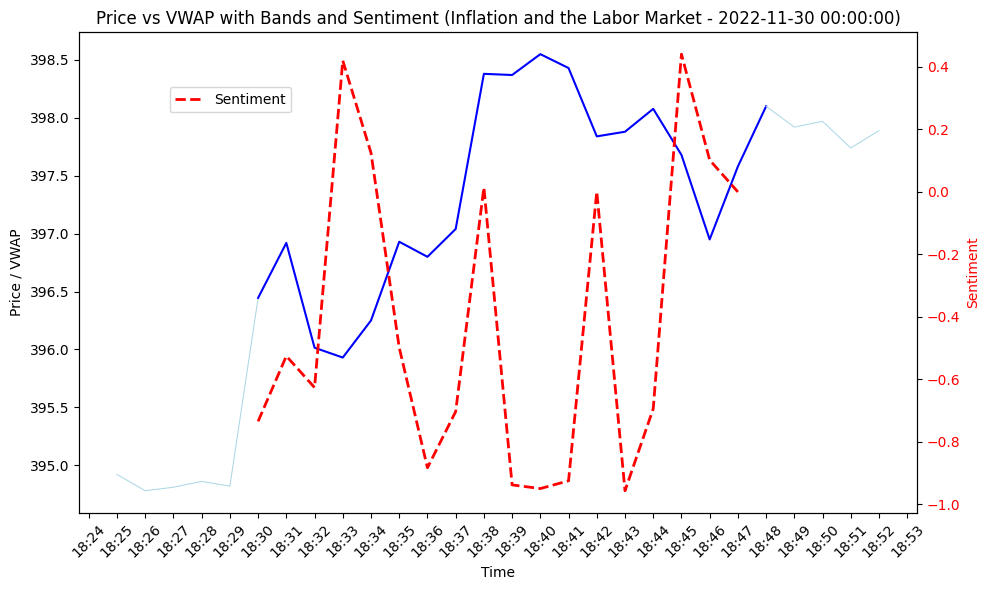

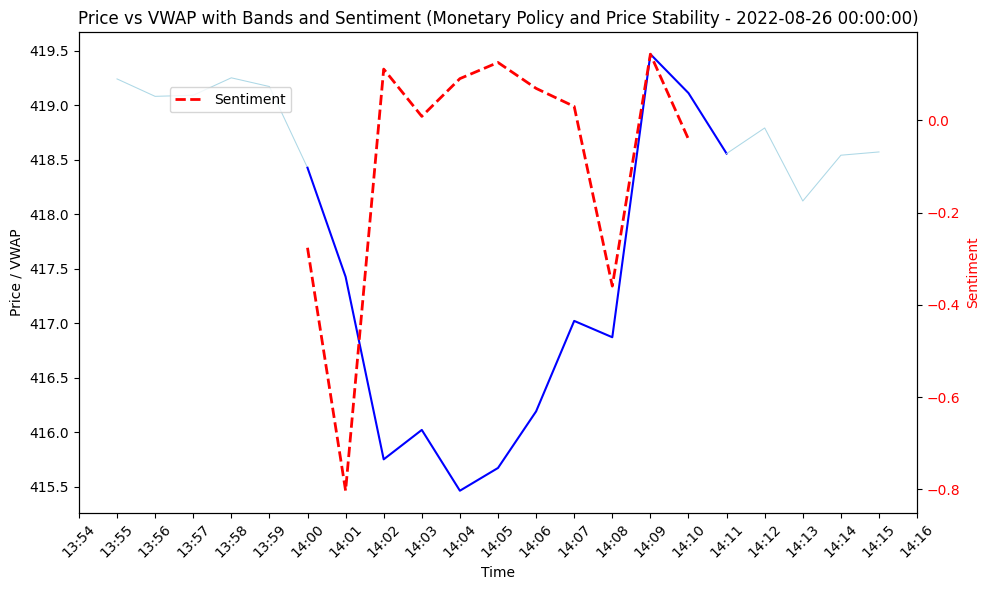

In [ ]:
df = find_best_volatility(top_n , df_speech_final)
plot_pricevssentiment(df_speech_final , df)

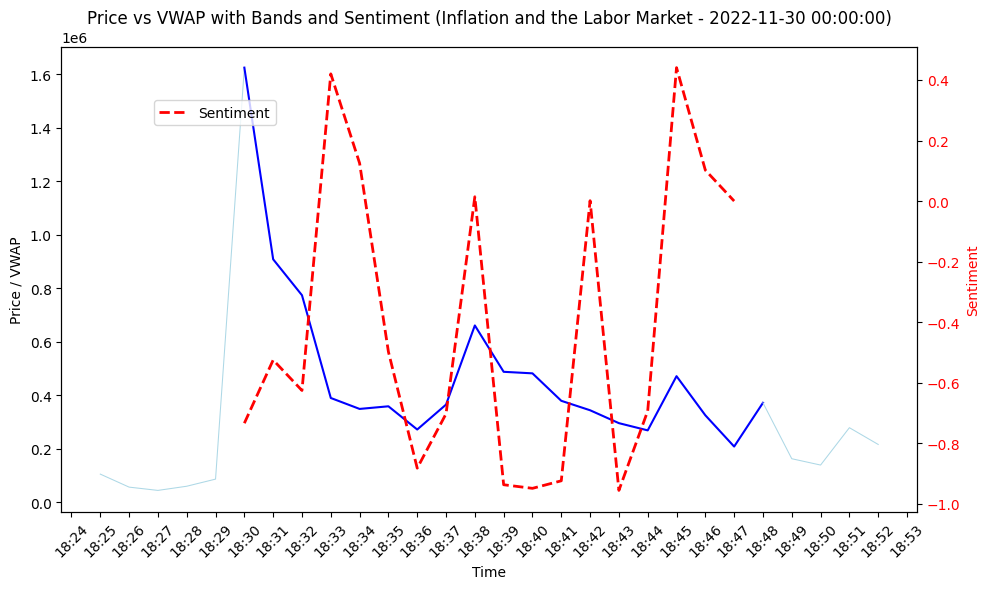

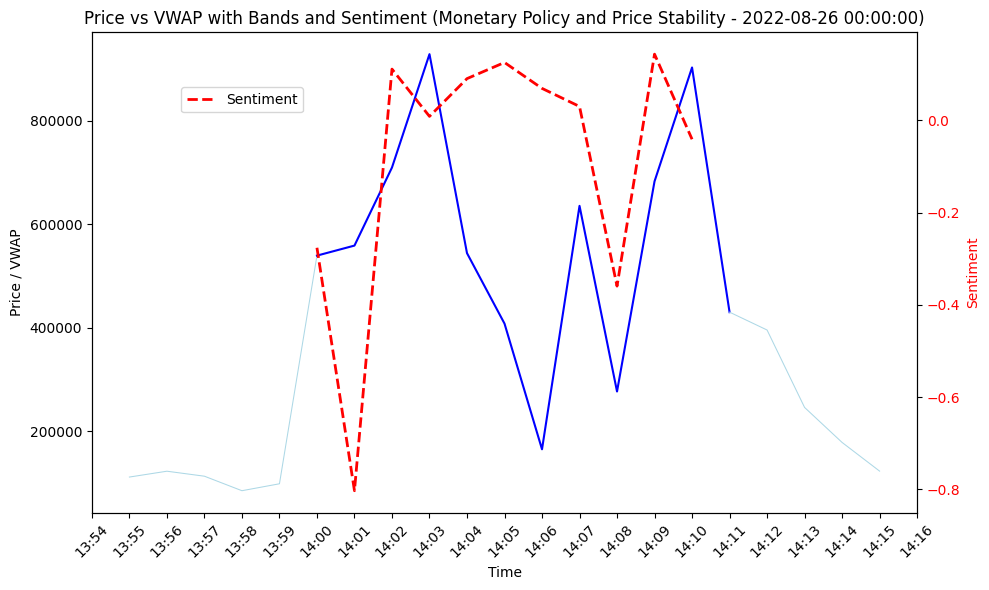

In [ ]:
plot_volumevssentiment(df_speech_final , df)

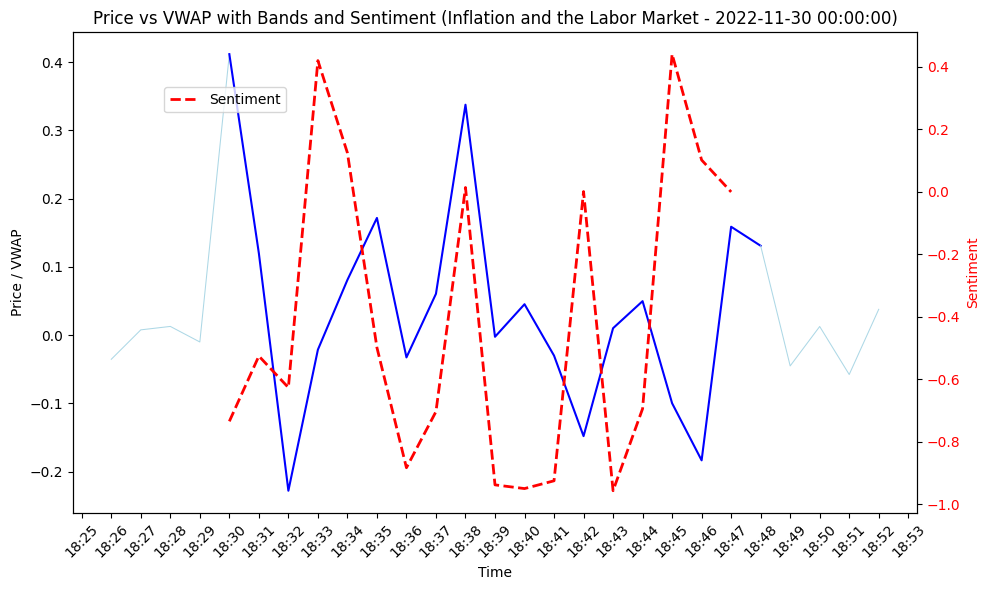

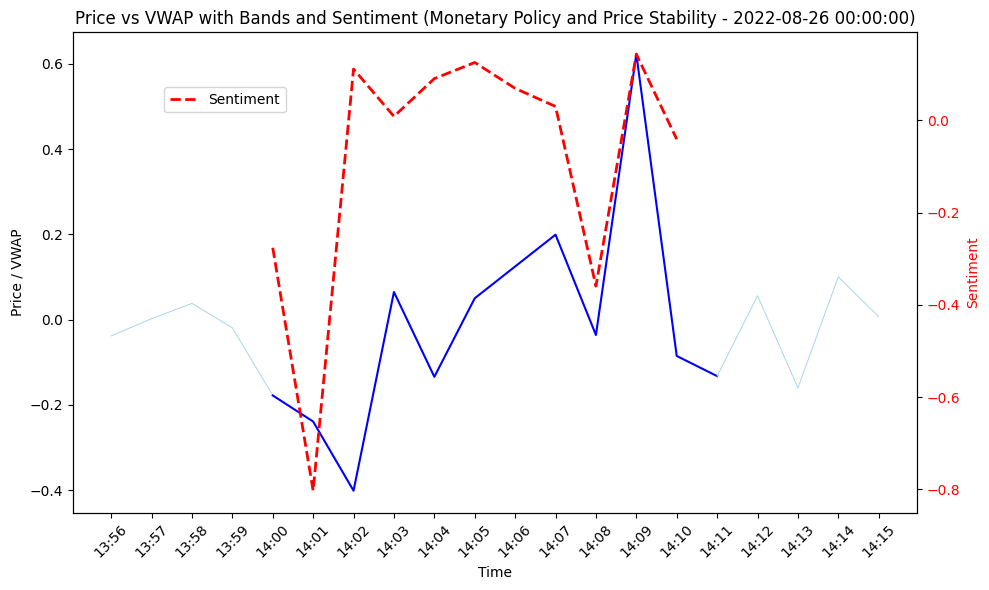

In [ ]:
plot_pctchangevssentiment(df_speech_final , df)

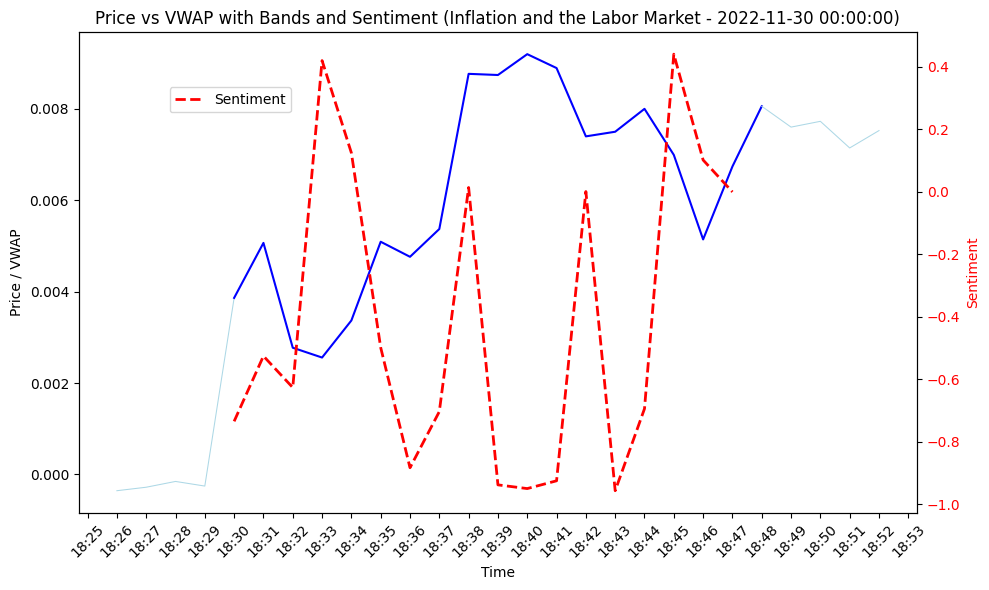

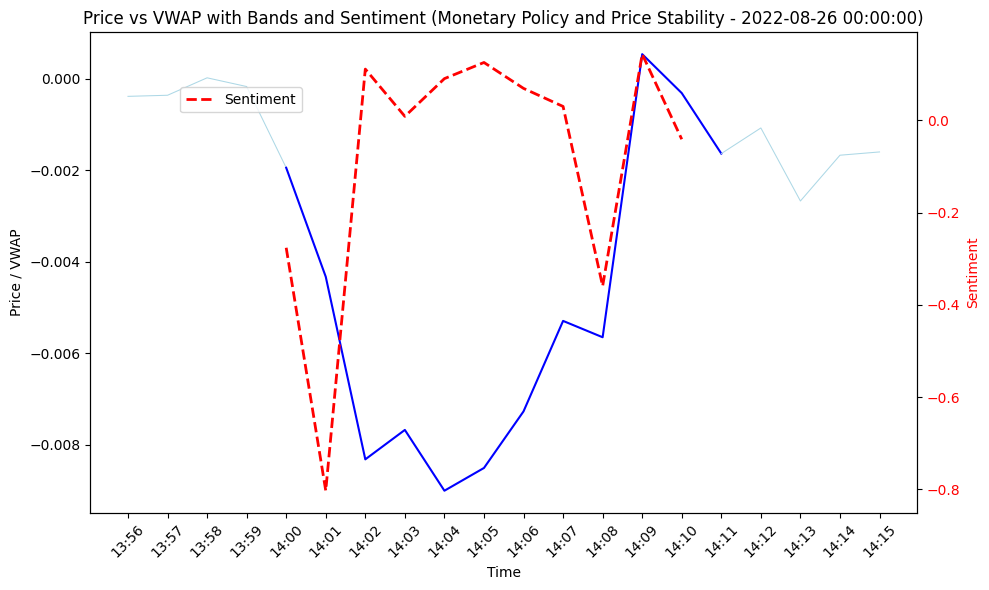

In [29]:
plot_cumretvssentiment(df_speech_final, df)